#1. Ejemplo del método de clasificación Naive Bayes
#Urban Land Cover Data Set

Number of instances 168

Number of Attributes 148

Contiene datos de entrenamiento y prueba para clasificar una imagen aérea de alta resolución en 9 tipos de cobertura de suelo urbano. Para la clasificación se utiliza información espectral, de tamaño, forma y textura de múltiples escalas. Hay un número bajo de muestras de entrenamiento para cada clase (14-30) y un gran número de variables de clasificación (148), por lo que puede ser un conjunto de datos interesante para probar métodos de selección de características. El conjunto de datos de prueba proviene de una muestra aleatoria de la imagen.

Las clases de cobertura terrestre son: árboles, césped, suelo, hormigón, asfalto, edificios, coches, piscinas, sombras.


#2. Importación de librerías y montando google drive

In [ ]:
import ___ as np
import matplotlib.pyplot as ___
import ____ as pd
import seaborn as ____
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import itertools
from sklearn import metrics

# 3. Lectura y visualuzación del dataset




In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.4 Naive Bayes'
train_path = os.path.join(___,'training.csv')
test_path = os.path.join(___,'testing.csv')


In [ ]:
train_df = pd.read_csv(____)
test_df = pd.read_csv(____)
clases = train_df['label'].unique()
train_df.dropna(axis=0, inplace=True)
_____.head(10)

,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,21.41,20.40,18.69,2.19,0.48,0.87,6.23,1.60,0.74,-0.08,56,4219.69,1.33,97,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,...,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36,1.33,97,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,6.57,6.97,7.02,1.52,0.45,0.63,6.35,1.55,0.69,-0.10,156,3682.08,3.01,1188,1.45,209.44,2.25,3.54,181.91,222.46,223.95,9.82,10.37,10.51,2.97,0.63,0.65,7.16,1.43,0.83,...,1.66,211.94,2.90,4.97,186.31,223.83,225.68,22.62,22.92,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14,4.57,7711,1.66,211.94,2.90,4.97,186.31,223.83,225.68,22.62,22.92,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,6.16,4.93,5.53,1.14,0.52,0.78,6.19,1.88,0.19,-0.08,144,2943.35,2.32,1095,1.50,232.50,1.93,2.55,208.36,244.07,245.08,6.55,7.01,6.83,2.19,0.49,0.74,6.51,1.61,0.81,...,1.17,222.97,1.87,2.08,201.51,232.96,234.43,15.35,15.93,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04,1.93,4606,1.17,222.97,1.87,2.08,201.51,232.96,234.43,15.35,15.93,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,5.76,5.56,5.46,2.51,0.50,0.74,6.28,1.51,0.83,-0.09,218,3550.19,3.16,4009,2.28,231.57,3.48,3.47,204.77,245.17,244.76,9.55,9.35,9.34,2.27,0.63,0.62,7.04,1.32,0.84,...,1.41,226.65,2.06,2.88,200.18,239.93,239.83,13.69,13.75,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38,2.41,10482,1.41,226.65,2.06,2.88,200.18,239.93,239.83,13.69,13.75,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,11.46,8.90,9.77,12.26,0.71,0.59,7.36,0.63,0.99,-0.11,504,2300.41,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,11.46,8.90,9.77,12.26,0.71,0.59,7.36,0.63,0.99,...,2.37,193.39,5.03,12.06,172.13,203.14,204.91,17.38,14.93,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38,3.34,16680,2.37,193.39,5.03,12.06,172.13,203.14,204.91,17.38,14.93,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38
5,tree,3.11,169,1.47,172.22,2.49,3.35,240.18,127.65,148.83,8.41,10.34,11.50,1.87,0.43,0.55,6.44,1.38,0.70,0.31,174,4707.12,3.25,747,1.55,161.30,2.53,3.33,228.44,117.25,138.20,16.32,14.66,15.47,1.02,0.74,0.69,7.54,1.81,0.55,...,1.50,161.92,2.00,3.35,222.62,121.92,141.23,29.25,26.42,26.38,2.31,0.84,0.79,8.17,1.80,0.68,0.29,866,943.96,3.05,4174,1.50,161.92,2.00,3.35,222.62,121.92,141.23,29.25,26.42,26.38,2.31,0.84,0.79,8.17,1.80,0.68,0.29,866,943.96
6,car,1.20,44,0.79,208.80,1.14,1.36,180.95,221.61,223.82,35.42,36.45,35.17,2.00,0.54,0.89,5.84,1.58,0.63,-0.10,36,4340.51,1.20,44,0.79,208.80,1.14,1.36,180.95,221.61,223.82,35.42,36.45,35.17,2.00,0.54,0.89,5.84,1.58,0.63,...,1.86,112.58,2.53,3.36,99.39,116.71,121.65,50.10,53.91,53.36,2.09,0.87,0.62,8.47,1.46,0.81,-0.08,700,879.82,3.13,2706,1.86,112.58,2.53,3.36,99.39,116.71,121.65,50.10,53.91,53.36,2.09,0.87,0.62,8.47,1.46,0.81,-0.08,700,879.82
7,car,1.00,88,0.22,234.51,1.11,1.12,208.50,246.48,248.56,12.30,11.29,8.81,2.00,0.44

In [ ]:
____.groupby('label').size()

label
0    45
1    97
2    21
3    93
4    83
5    14
6    45
7    20
8    89
dtype: int64

#4. Escalamiento

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.____(train_df.loc[:, train_df.columns != 'label'])
test_df.loc[:, test_df.columns != 'label'] = scaler.____(test_df.loc[:, test_df.columns != 'label'])

#5. Codificación de etiquetas

In [ ]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)
test_df['label'] = le.transform(test_df.label.values)

In [ ]:
train_df['label']
train_df.head(10)

,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,2,0.084639,0.022198,0.331010,0.935481,0.105405,0.126543,0.821811,0.948658,0.958537,0.532585,0.501899,0.482040,0.078135,0.513158,0.833333,0.623762,0.583333,0.734694,0.373333,0.076923,0.442439,0.086387,0.008382,0.331325,0.913406,0.062745,0.076110,0.803303,0.929434,0.941129,0.465703,0.526282,0.491255,0.045188,0.493976,0.821429,0.301325,0.671958,0.680851,...,0.168126,0.912669,0.018987,0.029197,0.816789,0.929677,0.941030,0.371188,0.425521,0.395714,0.019786,0.274194,0.824324,0.000000,0.682464,0.677419,0.394366,0.000000,1.000000,0.049699,0.000000,0.168126,0.912669,0.018987,0.029197,0.816789,0.929677,0.941030,0.371188,0.425521,0.395714,0.019786,0.274194,0.824324,0.000000,0.682464,0.677419,0.394366,0.000000,1.000000
1,3,0.426332,0.063305,0.536585,0.861931,0.394595,0.447531,0.728752,0.892742,0.896248,0.069847,0.109553,0.129792,0.034143,0.473684,0.525641,0.663366,0.553571,0.683673,0.346667,0.260073,0.362991,0.526178,0.149065,0.430723,0.826371,0.245098,0.524313,0.699292,0.862105,0.862999,0.081536,0.146506,0.152883,0.089019,0.650602,0.583333,0.589404,0.544974,0.819149,...,0.262697,0.837256,0.130098,0.353102,0.730144,0.867965,0.870611,0.283386,0.330299,0.326250,0.024733,0.741935,0.418919,0.698361,0.545024,0.795699,0.380282,0.273640,0.320902,0.537651,0.227094,0.262697,0.837256,0.130098,0.353102,0.730144,0.867965,0.870611,0.283386,0.330299,0.326250,0.024733,0.741935,0.418919,0.698361,0.545024,0.795699,0.380282,0.273640,0.320902
2,3,0.351097,0.070156,0.505226,0.939344,0.289189,0.354938,0.815412,0.959886,0.964681,0.057063,0.049956,0.084817,0.009192,0.565789,0.717949,0.610561,0.750000,0.173469,0.373333,0.238095,0.253822,0.345550,0.137073,0.445783,0.939443,0.182353,0.315011,0.824115,0.960614,0.963479,0.011001,0.075575,0.073418,0.053773,0.481928,0.690476,0.374172,0.640212,0.797872,...,0.176883,0.891801,0.057665,0.089416,0.804804,0.910012,0.912527,0.155976,0.207947,0.206607,0.023546,0.693548,0.675676,0.311475,0.687204,0.795699,0.408451,0.082578,0.218268,0.140060,0.134485,0.176883,0.891801,0.057665,0.089416,0.804804,0.910012,0.912527,0.155976,0.207947,0.206607,0.023546,0.693548,0.675676,0.311475,0.687204,0.795699,0.408451,0.082578,0.218268
3,3,0.445141,0.106605,0.439024,0.930748,0.402703,0.515432,0.806417,0.955585,0.953096,0.044590,0.068361,0.082704,0.099146,0.539474,0.666667,0.640264,0.529762,0.826531,0.360000,0.373626,0.343501,0.565445,0.512830,0.680723,0.934883,0.486275,0.509514,0.807173,0.965629,0.961957,0.075712,0.124974,0.127618,0.057388,0.650602,0.547619,0.549669,0.486772,0.829787,...,0.218914,0.909999,0.071027,0.162409,0.798271,0.942111,0.938395,0.126884,0.169788,0.169464,0.046300,0.790323,0.675676,0.377049,0.535545,0.913978,0.380282,0.181671,0.227301,0.212349,0.309741,0.218914,0.909999,0.071027,0.162409,0.798271,0.942111,0.938395,0.126884,0.169788,0.169464,0.046300,0.790323,0.675676,0.377049,0.535545,0.913978,0.380282,0.181671,0.227301
4,3,0.360502,0.255961,0.595819,0.751002,0.345946,0.938272,0.627347,0.784806,0.787430,0.222326,0.165936,0.212798,0.739330,0.815789,0.474359,0.996700,0.005952,0.989796,0.333333,0.897436,0.158808,0.301047,0.117602,0.515060,0.746641,0.250980,0.642706,0.624115,0.785021,0.787151,0.116911,0.115474,0.136903,0.508812,0.746988,0.511905,0.655629,0.121693,0.989362,...,0.387040,0.745525,0.279887,1.000000,0.

#7. Modelo de clasificación con Naive Bayes y k-fold CV




In [ ]:
Y_train = train_df.values[:,0]
X_train = train_df.____[:,1:]
Y_test = test_df.values[:,0]
X_test = test_df.____[:,1:]

In [ ]:
seed = 10
from sklearn.naive_bayes import GaussianNB 
NB =  GaussianNB()
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [ ]:
score = cross_val_score(NB, X_train, Y_train, cv=kfold, scoring="accuracy")
y_pred = cross_val_predict(NB, X_test, Y_test, cv=10)

score = metrics.accuracy_score(Y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.8086785009861933


In [ ]:
#Funciones para MC y métricas
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

Matriz de confusión

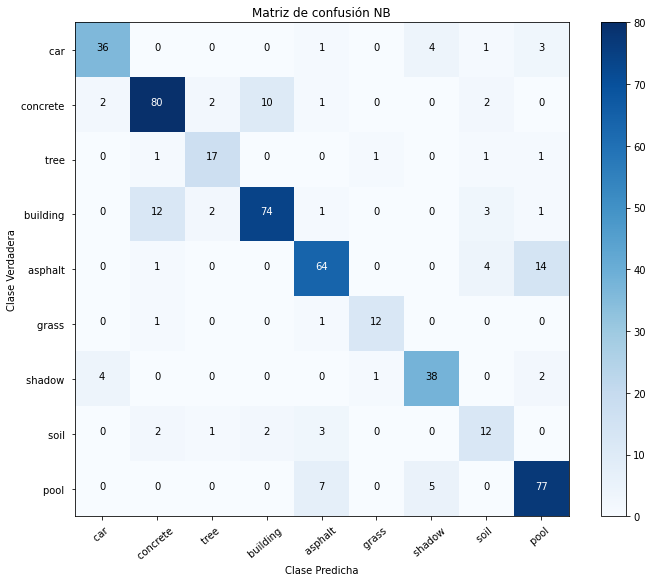

In [ ]:
n_clases = 9
predictions = np.float32(y_pred)
true_labels = np.float32(Y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión NB'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

Pesos por clase

In [ ]:
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
print(clases)
print(pesos)

['car ' 'concrete ' 'tree ' 'building ' 'asphalt ' 'grass ' 'shadow '
 'soil ' 'pool ']
[0.08333333 0.14880952 0.08928571 0.13690476 0.17261905 0.08928571
 0.0952381  0.08333333 0.10119048]


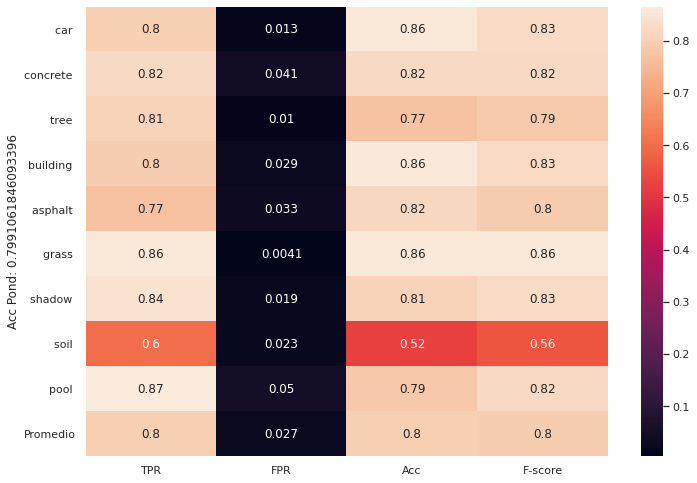

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases.tolist()+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)